## xcube Data Cube Generator with custom Processing

This notebook provides a walk-through demonstrating how to use a data cube generator in combination with _custom processing_.

<div class="alert alert-success">
    Warning: custom processing is still in development and not yet available in the current xcube production service. 
    Therefore this Notebook is using the development server.
</div>

---
Uncomment configuration using Dask Distributed. 

In [27]:
# from dask.distributed import Client
# client = Client(processes=True)

---

## Introduction

We first use the [Local Data Cube Generator](./2_local.ipynb) to generate the source cube that will be used as test data for the algorithm development.
Towards completion of development the the [Data Cube Generator Service](./3_service.ipynb) is used to process a larger dataset with the algorithm executed server-side.

Both the local Data Cube Generator and the Cube Generator Service clients use the same generator request format. It comprises specification of data sources (`input_config`), the data cube parameters (`cube_config`), the optional specification of optional user code (`code_config`), and finally the specification of the data sink (`output_config`). The `input_config` and `output_config` specifications refernce instances of _xcube Data Stores_ (see dedicated example Notebooks).

![image.png](./generator.png)

This Notebook comprises four sections that describe a typical algorithm development process with xcube BYOA:

**TODO: turn into section links**

1. Fetch subset source cube
2. Develop algorithm and apply to subset source cube
3. Package algorithm and test with subset source cube
4. Run algorithm on full dataset using the generator service

# 1. Fetch subset Source Cube

Here is how we create _cube Generator Request_ from Python classes. 
First import the relevant classes for setting up a generator request, then
we define the input, output and the cube characteristics, finally the request.

In this example we first use the **Sentinel Hub** data store as input and 
a **local directory** (the current one) data store as output:

In [39]:
from xcube.core.gen2 import CubeGeneratorRequest
from xcube.core.gen2 import InputConfig
from xcube.core.gen2 import CubeConfig
from xcube.core.gen2 import OutputConfig

input_config = InputConfig(
    store_id="sentinelhub",
    data_id="S2L2A",
    open_params=dict(
        time_tolerance="30m"
    )
)

cube_config = CubeConfig(
   variable_names=['B04', 'B05', 'B06', 'B11', 'SCL', 'CLD'],
   tile_size=[512, 512],
   spatial_res=0.00018,                      # = 20.038 meters in degree
   bbox=[10.37, 54.28, 10.52, 54.33],        # in degrees --> ~ 1000 x 300 pixels
   time_period="4D",                         # average over 4 days
   time_range=['2019-07-21', '2019-08-21'],  # 1 month / 4 days --> 8 time steps       
)

output_config = OutputConfig(
    store_id="directory",
    store_params=dict(
        base_dir="."
    ),
    replace=True,
    data_id="cube.zarr"
)

request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    output_config=output_config
)
request

Import the generator class, the instantiate the generator object:

In [40]:
from xcube.core.gen2 import LocalCubeGenerator

local_generator = LocalCubeGenerator(request)

Get some information about the cube that would be generated by `local_generator` (this may take seconds to minutes):

In [41]:
cube_info = local_generator.get_cube_info()
cube_info

Now perform the actual cube generation (again, this may take seconds to minutes):

**TODO: show progressbar!**

In [42]:
cube_id = local_generator.generate_cube()
cube_id

'cube.zarr'

Let's open the generated cube:

In [43]:
import xarray as xr
source_cube = xr.open_zarr(cube_id)
source_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 278, lon: 1024, time: 8)
Coordinates:
  * lat        (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon        (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time       (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-08-20
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(8, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    date_created:              2021-07-03T12:02:54.087569
    geospatial_lat_max:        54.330040000000004
    geospatial_lat_min:        54.28
    geospatial_lon_max:        10.554319999999999
    geospatial_lon_min:        10.37
    ...                        ...
    processing_level:          L2A
    time_coverage_duration:    P32DT0H0M0S
    time_coverage_end:         2019-08-22T00:00:00+00:00
    time_coverage_resolution:  P4DT0H0M0S
    time_coverage_start:       2019-07-21T00:00:00+00:00
    title:                     S2L2A Data Cube Subset

## 2. Algorithm Development

Now that we have the data cube, we want to start some algorithm development. Namely, we want to generate a new data layer called _Maximum Chlorophyll Index (MCI)_ for inland waters from the S2L2A bands `B04`, `B05`, and `B06`. 

In [44]:
source_cube.B05

<xarray.DataArray 'B05' (time: 8, lat: 278, lon: 1024)>
dask.array<open_dataset-b68a833bb8afb822b699210a95c8ea12B05, shape=(8, 278, 1024), dtype=float32, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-08-20
Attributes:
    bandwidth:     15.5
    bandwidth_a:   15
    bandwidth_b:   16
    resolution:    20
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    703.95
    wavelength_a:  704.1
    wavelength_b:  703.8

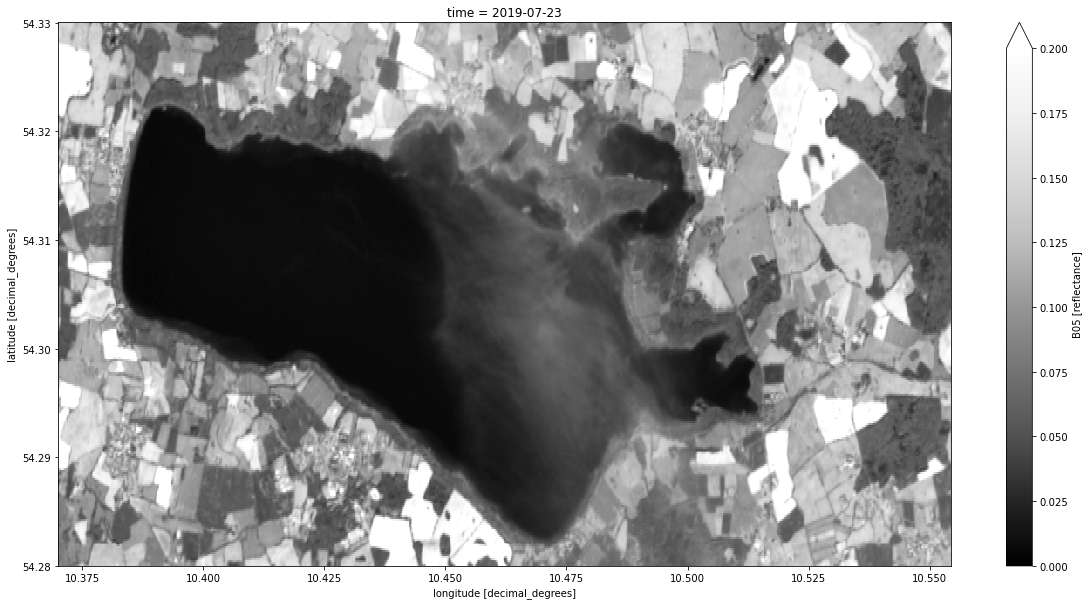

In [45]:
source_cube.B05.isel(time=0).plot.imshow(figsize=(20, 10), vmin=0, vmax=0.2, cmap='Greys_r')

We want the algorithm to operator only on work on water pixels. 
Luckily the S2L2A dataset above provides some _scene classification flags_ in variable `SCL` that we can
use to mask out unwanted land and cloud pixels.

In [46]:
from xcube.core.maskset import MaskSet

In [47]:
scene_classif = MaskSet(source_cube.SCL)
scene_classif

Flag name,Mask,Value
no_data,None,0
saturated_or_defective,None,1
dark_area_pixels,None,2
cloud_shadows,None,3
vegetation,None,4
bare_soils,None,5
water,None,6
clouds_low_probability_or_unclassified,None,7
clouds_medium_probability,None,8
clouds_high_probability,None,9


In [48]:
scene_classif.water

<xarray.DataArray 'water' (time: 8, lat: 278, lon: 1024)>
dask.array<where, shape=(8, 278, 1024), dtype=uint8, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-08-20

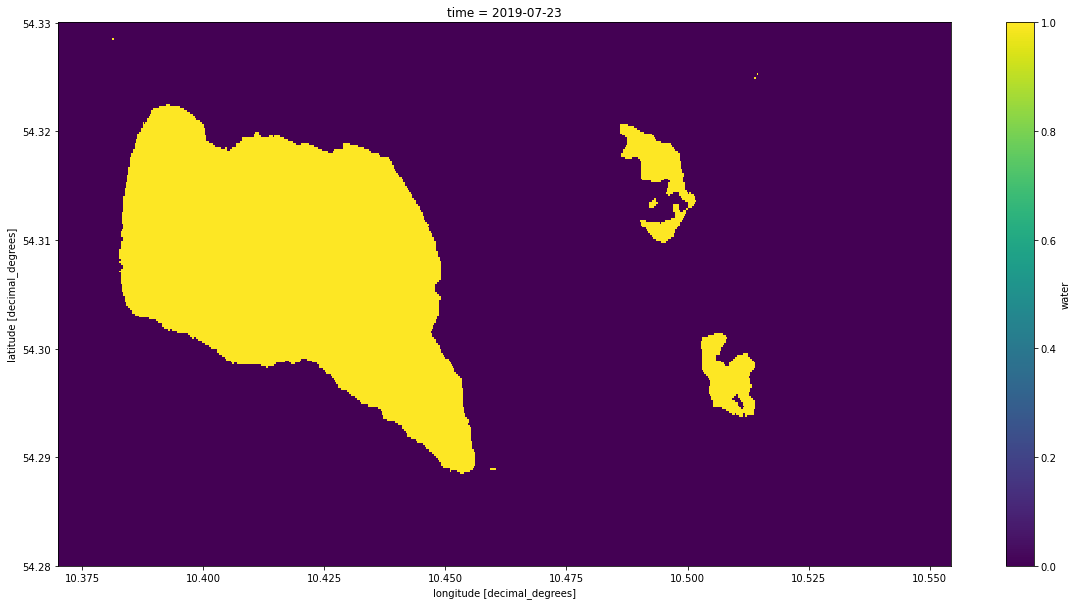

In [49]:
scene_classif.water.isel(time=0).plot.imshow(figsize=(20, 10))

We'll now code the algorithm:

In [50]:
from typing import Any, Dict
import numpy as np


def compute_mci_var(b_from: np.ndarray, 
                    b_peek: np.ndarray,
                    b_to: np.ndarray, 
                    input_params: Dict[str, Any], 
                    dim_coords: Dict[str, np.ndarray]):
    """Compute Maximum Chlorophyll Index (MCI) from three reflectances."""
    
    # The first three arguments are chunks of the three input variables we define below. 
    # You can name them as you like. They are pure 3D numpy arrays.
    
    # The 'input_params' argument is a standard parameter that we define in the call below.
    wlen_from = input_params['wlen_from']
    wlen_peek = input_params['wlen_peek']
    wlen_to = input_params['wlen_to']
    
    # The 'dim_coords' argument is optional and provides the coordinate values for all dimension 
    # of the current chunk. We don't use it here, but for many algorithms this is important 
    # information (e.g. looking up aux data).
    lon, lat = (dim_coords[dim] for dim in ('lon', 'lat'))
    # print('dim_coords from', lon[0], lat[0], 'to', lon[-1], lat[-1])
    
    # You can use any popular data packages such as numpy, scipy, dask here,
    # or we can use ML packages such as scikitlearn!
    # For simplity, we do some simple array math here:

    f = (wlen_peek - wlen_from) / (wlen_to - wlen_from)
    mci = (b_peek - b_from) - f * (b_to - b_from)

    return mci

We now write the actual _dataset processor function_. We already code in the way xcube expects it for the generator service. This is, the function's first argument is the data cube (of type `xr.Dataset`) generated so far according to `cube_config` and `input_config` xcubes expects it to. The remaining keyword-arguments are later provided by the user through the `code_config` object. The return value must again be a data cube (of type `xr.Dataset`).

We use the xcube function `compute_cube` to apply our MCI-algorithm to each of the cube's chunks. Finally we store some metadata in our output.

In [51]:
from xcube.core.compute import compute_cube

def compute_mci_cube(source_cube: xr.Dataset, **processing_params) -> xr.Dataset:
    """
    Compute a new data cube with a single variable 'mci' (Maximum Chlorophyll Index) 
    from three reflectances.
    
    Note the parameter *processing_params* can be used to pass user-defined
    parameters into the function. However, they are not used here.
    """
    
    # Mask out non-water pixels
    scene_classif = MaskSet(source_cube.SCL)    
    water_cube = source_cube.where(scene_classif.water)
    
    input_params = dict(wlen_from=water_cube.B04.attrs['wavelength'],
                        wlen_peek=water_cube.B05.attrs['wavelength'],
                        wlen_to=water_cube.B06.attrs['wavelength'])
    
    # concurrently compute the cube; chunks are processed in parallel
    mci_cube = compute_cube(compute_mci_var, 
                            water_cube, 
                            input_var_names=['B04', 'B05', 'B06'], 
                            input_params=input_params, 
                            output_var_name='MCI')
    # the MCI variable
    mci = mci_cube['MCI']

    # Return a copy of the source cube plus the MCI variable
    mci.attrs['long_name'] = 'Maximum Chlorophyll Index'
    mci.attrs['units'] = 'unitless'

    # Return a copy of the source cube plus the MCI variable
    return source_cube.assign(MCI=mci)    

In [52]:
mci_cube = compute_mci_cube(source_cube)
mci_cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 278, lon: 1024, time: 8)
Coordinates:
  * lat        (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon        (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time       (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-08-20
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(8, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
    MCI        (time, lat, lon) float64 dask.array<chunksize=(1, 278, 512), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    date_created:              2021-07-03T12:02:54.087569
    geospatial_lat_max:        54.330040000000004
    geospatial_lat_min:        54.28
    geospatial_lon_max:        10.554319999999999
    geospatial_lon_min:        10.37
    ...                        ...
    processing_level:          L2A
    time_coverage_duration:    P32DT0H0M0S
    time_coverage_end:         2019-08-22T00:00:00+00:00
    time_coverage_resolution:  P4DT0H0M0S
    time_coverage_start:       2019-07-21T00:00:00+00:00
    title:                     S2L2A Data Cube Subset

The dataset looks ok, now visually inspect MCI:

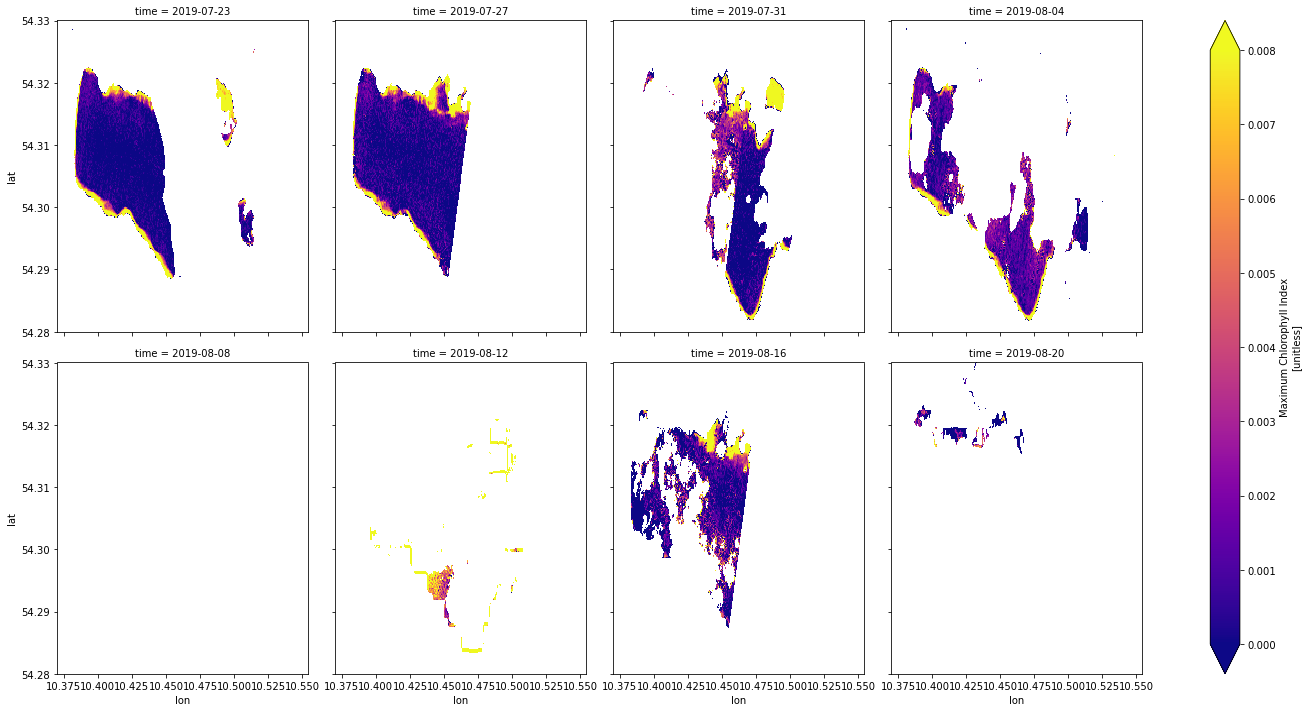

In [53]:
mci_cube.MCI.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=0.008, cmap='plasma', figsize=(20, 10))

## 3. Algorithm Packaging

We now have a tiny local data cube and a working algorithm. Now the final goal is to scale up and 
run the algorithm remotely, on much more data, and with much much more computational power.

Before we proceed to the xcube Generator Service, we will try running the local cube generator 
with our code. This will allow us finding bugs early, which is much harder with the algorithm 
running in the cloud. If it runs fine locally, we have more confidence when running the 
algorithm remotely.

Because the `compute_mci_cube()` function comprises we very little code, we use the
`CodeConfig.from_code()` method to create a code configuration that uses one single inline code
string which will be passed to the generator: 

In [54]:
from xcube.core.gen2 import CodeConfig

code_config = CodeConfig.from_code(
    # Pass required imports as inline code.    
    "from typing import Any, Dict",
    "import numpy as np",
    "import xarray as xr",
    "from xcube.core.maskset import MaskSet",
    "from xcube.core.compute import compute_cube",
    # Functions can be passed as references
    compute_mci_cube,
    compute_mci_var
)

In [55]:
# Call code_config.get_callable() to test whether code_config is valid.
# If it is valid, it should return a function refernce.
code_config.get_callable()

<function xcube_byoa_2.compute_mci_cube(source_cube: xarray.core.dataset.Dataset, **processing_params) -> xarray.core.dataset.Dataset>

If our code base grows we should consider developing a Python module. Then we can provide this
directly or pack it as a ZIP or even host it on GitHub and use a GitHub release:

* `code_config.from_code(*code, ...)` - creates an inline code string configuration
* `code_config.from_callable(function, ...)` - creates a Python module and a code configuration for it
* `code_config.from_file_set(file_set, ...)` - creates a code configuration for a Python module (directory or Zip archive), local or remote (you can use URLs with `https` or `s3` protocol)
* `code_config.from_github_archive(gh:org, gh_repo, ...)` - creates a code configuration for a GitHub archive

In [56]:
request_with_code = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    code_config=code_config,  # NEW!
    output_config=output_config
)
request_with_code

Now we try running the code with the Cube generator (may take seconds to minutes again).

**TODO: show progressbar!**

In [22]:
local_generator = LocalCubeGenerator(request_with_code)
cube_id = local_generator.generate_cube()

In [23]:
source_cube = xr.open_zarr(cube_id)
source_cube.MCI

<xarray.DataArray 'MCI' (time: 16, lat: 278, lon: 1024)>
dask.array<open_dataset-92eb1b08f9e95719cbab2ad0a65fdf98MCI, shape=(16, 278, 1024), dtype=float64, chunksize=(1, 278, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 54.33 54.33 54.33 54.33 ... 54.28 54.28 54.28 54.28
  * lon      (lon) float64 10.37 10.37 10.37 10.37 ... 10.55 10.55 10.55 10.55
  * time     (time) datetime64[ns] 2019-07-23 2019-07-27 ... 2019-09-21
Attributes:
    long_name:  Maximum Chlorophyll Index
    units:      unitless

## 4. BYOA Cube Generator Service

**TODO: describe whats going on here**

In [57]:
input_config = InputConfig(
    store_id="@sentinelhub_eu",
    data_id="S2L2A",
    open_params=dict(
        time_tolerance="30m"
    )
)

output_config = OutputConfig(
    store_id="@eurodatacube_scratch",
    replace=True,
    data_id="my_mci_cube.zarr"
)

service_request = CubeGeneratorRequest(
    input_config=input_config,
    cube_config=cube_config,
    code_config=code_config,
    output_config=output_config
)
service_request

**TODO: describe whats going on here**

In [58]:
import yaml
from xcube.core.gen2.service import ServiceConfig

with open('../../../edc-service.yml') as fp:
    service_config_json = yaml.safe_load(fp)
    
service_config = ServiceConfig.from_dict(service_config_json)

**TODO: describe whats going on here**

**TODO: add progressbar!**

In [59]:
from xcube.core.gen2.service import CubeGeneratorService

generator_service = CubeGeneratorService(service_request, service_config, verbosity=1)
data_id = generator_service.generate_cube()
data_id

CubeGeneratorError: 500 Server Error: INTERNAL SERVER ERROR for url: https://stage.xcube-gen.brockmann-consult.de/api/v2/cubegens: The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.

Let's open the generated cube. Cubes generated into the store "@eurodatacube_scratch" 
can be accessed via URL template 

    https://s3.eu-central-1.amazonaws.com/eurodatacube-scratch/{cube_id}

We use the xcube function `open_cube` to open cubes from a URL: 

In [ ]:
from xcube.core.dsio import open_cube

cube = open_cube(f'https://s3.eu-central-1.amazonaws.com/eurodatacube-scratch/{cube_id}')
cube